In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import math
from scipy.optimize import curve_fit, minimize
from itertools import combinations, product
from scipy.interpolate import griddata
from matplotlib.colors import Normalize
from multiprocessing import Pool

from IPython.display import clear_output

SVPN solution on dislocation profile.

/tmp/ipykernel_25992/2169448450.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  return np.clip(1/np.tan(x), 1e-8, 1e8)


disloction line angle 0.0, b1=3.1, b3=3.37
001 energy factor: K11 0.05121494483588271 K33 0.11148181326937998 K13 0.0
001 shear modulus 224.45102813641847 poisson ratio 0.2060613211215978
best result: [20.90543635 21.16826716  0.25457349  0.71638037] E=-1.897770845390543


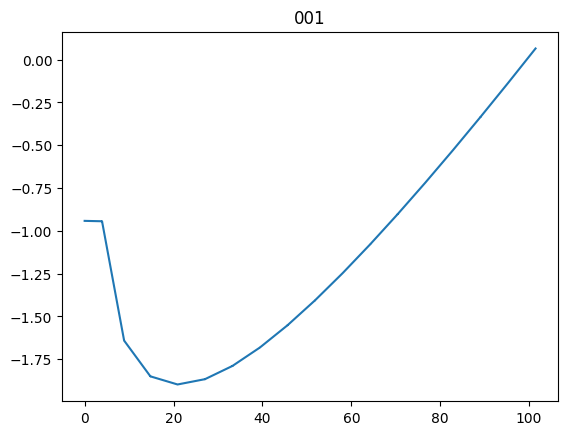

In [29]:
def shear_mod(cij, n, m):
    sij = np.linalg.inv(cij)
    s11, s12, s13, s33, s44, s66 = sij[0,0], sij[0,1], sij[0,2], sij[2,2], sij[3,3], sij[5,5]
    n1, n2, n3 = n
    m1, m2, m3 = m
    
    t1 = 4*(2*s12 - (s11+s11-s66))*n1*n2*m1*m2
    t2 = 4*(2*s13 - (s11+s33-s44))*n2*m2*n3*m3
    t3 = 4*(2*s13 - (s33+s11-s44))*n1*m1*n3*m3
    t4 = s44*(n2*m3-n3*m2)**2
    t5 = s44*(n3*m1-n1*m3)**2
    t6 = s66*(n1*m2-n2*m1)**2
    
    return 1/(t1+t2+t3+t4+t5+t6)

def s1111_derive(cij, n):
    sij = np.linalg.inv(cij)
    s11, s12, s13, s33, s44, s66 = sij[0,0], sij[0,1], sij[0,2], sij[2,2], sij[3,3], sij[5,5]
    n1, n2, n3 = n
    
    t1 = s11*n1**4 + s11*n2**4 + s33*n3**4
    t2 = (s44 + 2*s13)*n2**2*n3**2
    t3 = (s44 + 2*s13)*n1**2*n3**2
    t4 = (s66 + 2*s12)*n1**2*n2**2
    
    return t1 + t2 + t3 + t4

def s1122_derive(cij, n, m):
    ''' 
    return s_ijkl ni nj mk ml
    '''
    
    ind_map_tensor = {
        (0,0):0,
        (0,1):5,
        (0,2):4,
        (1,1):1,
        (1,2):3,
        (2,2):2,
        (1,0):5,
        (2,0):4,
        (2,1):3,
    }
    
    sij = np.linalg.inv(cij)
    
    s_1122 = 0
    ij_prod = [(i,j) for i, j in product(range(3), range(3))]
    
    for i, j in product(ij_prod, ij_prod):

        ind_tensor = [ind_map_tensor[i], ind_map_tensor[j]]
        nnmm = n[i[0]]*n[i[1]]*m[j[0]]*m[j[1]]
        s_1122 += sij[ind_tensor[0], ind_tensor[1]]*nnmm
        
    return s_1122

class energy_fac:
    def __init__(self, stiffness_tensor, a, c):
        c11 = stiffness_tensor[0,0]
        c12 = stiffness_tensor[0,1]
        c13 = stiffness_tensor[0,2]
        c33 = stiffness_tensor[2,2]
        c44 = stiffness_tensor[3,3]
        c66 = 1/2*(c11-c12)
        
        self.b0 = c66
        self.rho = c44 - c66
        self.k = c11*c44
        self.l = (c11*c33 - c13**2) -2*c44*(c11 + c13)
        self.m = (c11*c33-c13**2)-c44*(c11+c33+2*c13)
        self.delta13 = c11*c33 - c13**2
        self.g = c11*c33 - (c13+2*c44)**2
        self.lp_a, self.lp_c = a, c 
        
        self.lattice_vec = np.array([[a, 0, 0], [-a/2, a*np.sqrt(3)/2, 0], [0, 0, c]])
    
    def vec_proj(self, vec, disloc_):
        
        disloc = disloc_.copy()
        vec_dislocproj = np.dot(vec, disloc)*disloc
        vec_perp = vec - vec_dislocproj
        
        return np.linalg.norm(vec_dislocproj), np.linalg.norm(vec_perp)
    
    def cot(self, x):
        return np.clip(1/np.tan(x), 1e-8, 1e8)

    def angle_calc(self, a, b, mode='rad'):
        deg = np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))
        if mode == 'deg':
            return np.rad2deg(deg)
        
        if np.isnan(deg):
            return 0
        return deg
    
    def delta1_2(self, theta):
        return (self.k + self.l*np.sin(theta)**2 - self.m*np.sin(theta)**4)/self.k
    
    def delta2(self, theta):
        return (2*self.k+self.l*np.sin(theta)**2)/self.k
    
    def delta3_2(self, theta):
        return (self.b0 + self.rho*np.sin(theta)**2)/self.b0
    
    def s1(self, theta):
        delta_13, delta3_2 = self.delta13, self.delta3_2(theta)
        num = self.b0**2*(self.g*np.cos(theta)**4 + delta_13*delta3_2**2)
        den = 2*self.k*(self.b0+self.rho)**2
        
        return num/den
    
    def s2(self, theta):
        delta3_2 = self.delta3_2(theta)
        num = 4*self.b0**2*delta3_2*self.cot(theta)**2
        den = (self.b0+self.rho)**2
        
        return num/den

    def s3(self, theta):
        delta13 = self.delta13
        delta3_2 = self.delta3_2(theta)
        
        num = self.b0*np.sin(2*theta)* \
            (delta13*self.rho*delta3_2 - self.g*self.b0*np.cos(theta)**2)
        den = 4*self.k*(self.b0 + self.rho)**2
        
        return num/den 
    
    def s4(self, theta):
        num = 2*self.b0*self.cot(theta)*(self.b0 - self.rho*np.cos(theta*2))
        den = (self.b0+self.rho)**2
        
        return num/den
    
    def s5(self, theta):
        delta13 = self.delta13
        num = (self.g*self.b0**2 + delta13*self.rho**2)*np.sin(2*theta)**2
        den = 8*self.k*(self.b0+self.rho)**2
        
        return num/den

    def s6(self, theta):
        num = 4*self.rho*self.b0*np.cos(theta)**2
        den = (self.b0+self.rho)**2
        
        return num/den
    
    def main(self, disloc_line,
             burgers_vec=np.array([1,0,1]),
             print_=False):
        
        disloc_line /= np.linalg.norm(disloc_line)
        
        if disloc_line[2] < 0:
            disloc_line = -disloc_line
        
        theta = self.angle_calc(disloc_line, np.array([0,0,1]))
        
        b_vec = burgers_vec@self.lattice_vec
        b3, b1 = self.vec_proj(b_vec, disloc_line)
        b2 = 0
        len_b = np.linalg.norm(b_vec)
        
        s1, s2, s3, s4, s5, s6 = [getattr(self, f's{i}')(theta) for i in range(1,7)]
        delta3_, delta1_ = np.sqrt(self.delta3_2(theta)), np.sqrt(self.delta1_2(theta))
        
        for delta3, delta1 in zip([delta3_], [delta1_]):
            delta2 = self.delta2(theta)
            d = 1/2*np.sqrt(delta2 + 2*delta1)
            
            pre_fac = (self.b0 + self.rho)/d
            k11 = pre_fac*(s1 + s2*d*(delta3-d))
            k33 = pre_fac*(s5 + s6*d*(d-delta3)+d/delta3)
            k13 = pre_fac*(s3 + s4*d*(d-delta3))
        
        print(f'disloction line angle {round(np.rad2deg(theta), 2)}, b1={round(b1,3)}, b3={round(b3,3)}')
        
        return [k11, k33, k13], np.rad2deg(theta), [b1, b3]
    
def ft_main(xy, *coef, n_coef=8, print_=False):
    #* x, y should be normalized by a / c
    x, y = xy[:,0]*2, xy[:,1]*2
    c = coef[0]
    n = (len(coef)-1)//n_coef
    
    y_ft = c
    prefac = 1/2
    for i in range(1, n+1):
        for j_ in range(1,n_coef//8+1):
            j = 8*j_
            y_ft += \
                coef[n_coef*i-j+1]*np.sin(prefac**j_*i*np.pi*x + prefac**j_*i*np.pi*y) \
              + coef[n_coef*i-j+2]*np.cos(prefac**j_*i*np.pi*x + prefac**j_*i*np.pi*y) \
              + coef[n_coef*i-j+3]*np.sin(prefac**j_*i*np.pi*x - prefac**j_*i*np.pi*y) \
              + coef[n_coef*i-j+4]*np.cos(prefac**j_*i*np.pi*x - prefac**j_*i*np.pi*y) \
              + coef[n_coef*i-j+5]*np.sin(prefac**j_*i*np.pi*x) \
              + coef[n_coef*i-j+6]*np.cos(prefac**j_*i*np.pi*x) \
              + coef[n_coef*i-j+7]*np.sin(prefac**j_*i*np.pi*y) \
              + coef[n_coef*i-j+8]*np.cos(prefac**j_*i*np.pi*y)
            
            if print_:
                print(prefac**j_*i)
            
    return y_ft
    
#* gaussian-type functional not optimal one
def u_x(x, disso_x, wx, b):
    deno = np.exp(-1/2*((x-disso_x/2)/wx)**2) + np.exp(-1/2*((x+disso_x/2)/wx)**2)
    rho_x = deno/np.sum(deno)
    return np.cumsum(rho_x)*b
    
#* vectorize version
def chi_ab_mat(x_mat_dict, dx):
    #* input variables are not optimize target
    def psi(x_mat):
        return 1/2*(x_mat**2)*np.log(np.abs(x_mat)+1e-8)
    
    term1 = 3/2*dx**2
    return term1 + (psi(x_mat_dict['x_x'])
                 - psi(x_mat_dict['x_x_dx'])
                 - psi(x_mat_dict['x_dx_x'])
                 + psi(x_mat_dict['x_dx_x_dx']))
    
def e_el_fast(rho11, rho33, chi_mat, k11, k33, k13=None):
    rho_mat_11 = rho11*rho11.reshape(-1,1)
    rho_mat_33 = rho33*rho33.reshape(-1,1)
    rho_mat_13 = rho11*rho33.reshape(-1,1)
    rho_mat_31 = rho33*rho11.reshape(-1,1)
    
    e = np.sum(k11 * rho_mat_11 * chi_mat) + np.sum(k33 * rho_mat_33 * chi_mat)
    if k13 is not None:
        e = e + np.sum(k13 * rho_mat_13 * chi_mat) + np.sum(k13 * rho_mat_31 * chi_mat)
        
    return e

def e_total(param,
            x, dx,
            chi_mat, 
            #* since k13 ~ 1/10 k11/k33 it's not the dominant factor
            k_11, k_33, k13, #* elastic part 
            gsfe_coef, n_coef, 
            b_11, b_33, #* misfit part
            disloc_mode
            ):
    
    d11, d33, w11, w33 = param
    
    ux_11 = u_x(x, d11, w11, b_11)
    ux_fin_11 = np.concatenate((ux_11, np.array([b_11])))
    ux_pre_11 = np.concatenate((np.array([0]), ux_11))
    rho_x_11 = (ux_fin_11 - ux_pre_11)/dx

    ux_33 = u_x(x, d33, w33, b_33)
    ux_fin_33 = np.concatenate((ux_33, np.array([b_33])))
    ux_pre_33 = np.concatenate((np.array([0]), ux_33))
    rho_x_33 = (ux_fin_33 - ux_pre_33)/dx

    if disloc_mode == '001':
        ux_frac = np.array([(ux_11 / b_11) % 1, (ux_33 / b_33) % 1]).T
    elif disloc_mode == '010':
        ux_frac = np.array([(ux_33 / b_33) % 1, (ux_11 / b_11) % 1]).T
        
    #* 2-d array
    ux_frac[ux_frac > 1/2] = 1 - ux_frac[ux_frac > 1/2]
    
    e_el_ = e_el_fast(rho_x_11, rho_x_33, chi_mat, k_11, k_33, k13)
    gamma_xy = ft_main(ux_frac, *gsfe_coef, n_coef=n_coef, print_=False)*mjm2eva
    e_ms_ = np.sum(gamma_xy * dx)
    
    return e_el_ + e_ms_

#TODO information dictionary on <a+c> slip pattern
mechan_dict = {}

mjm2eva = 6.24150965*1e-5 #* convert mJ/m^2 to eV/Å^2
element_list = [] #TODO specify the elements
compo_denote = '' #TODO denotion of composition
composition = np.array([]) #TODO composition
a, c = 0, 0 #TODO lattice parameter

n_coef = 8 #TODO specify the gsfe MAP coefficients
gsfe_coef = np.load(f'') 

b = np.sqrt(a**2+c**2) #* specify the Burgers vector
dx = a #TODO dx
x_list = np.arange(-100, 101)*dx
x_list_ = x_list[1:]

#* chi_mat is fixed
x_list_mat_dict = {
    'x_x': x_list_ - x_list_.reshape(-1,1),
    'x_x_dx': x_list_ - (x_list_-dx).reshape(-1,1),
    'x_dx_x': x_list_-dx - x_list_.reshape(-1,1),
    'x_dx_x_dx': x_list_ - x_list_.reshape(-1,1),}
chi_mat = chi_ab_mat(x_list_mat_dict, dx) #* return multiplication factor matrix

def disloc_line(a, c, mode, delta=None):
    return np.array([1.,0.,0.])

#TODO dislocation line infomation   
disloc_mode = '001'
b_vec = np.array([1,0,1])
pth_dataset = ''

#TODO computation method
compute_mode = 'direct'

if compute_mode == 'vegards':
    cij_list = [np.load(f'') for ele in element_list]
    a_list = [mechan_dict[ele]['a'] for ele in element_list]
    c_list = [mechan_dict[ele]['c'] for ele in element_list]
    stroh_tensor_list = [energy_fac(cij, a_, c_).main(
                disloc_line(a_, c_, disloc_mode), b_vec)[0][-1] for cij, a_, c_ in zip(
                cij_list, a_list, c_list)]
    ke = composition@np.array(stroh_tensor_list)/(4*np.pi*160.2176621)
    
elif compute_mode == 'direct':
    #TODO cij path
    cij = np.load(f'')
    k_list, theta, b_list = energy_fac(cij, a, c).main(disloc_line(a, c, disloc_mode), b_vec)
    
    k11 = k_list[0]/(4*np.pi*160.2176621)
    k33 = k_list[1]/(4*np.pi*160.2176621)
    k13 = k_list[2]/(4*np.pi*160.2176621)
    
    b1, b3 = b_list

#* initialization
energy_info = []
for x in np.linspace(0, 100, 41):
    
    param = [x, x, 1, 1]
    res = minimize(e_total, 
                x0 = param, 
                args = (x_list[1:-1], dx, chi_mat, 
                        k11, k33, k13, gsfe_coef, n_coef, 
                        b1, b3, disloc_mode),
                
                method='L-BFGS-B', 
                tol=1e-16, options={"ftol":1e-12, "gtol":1e-12,},
                )
    
    energy_info.append([res.x[0], res.x[1], res.x[2], res.x[3], res.fun])

print(f'{disloc_mode} energy factor: K11 {k11} K33 {k33} K13 {k13}')
energy_info = np.array(energy_info)

e_tot = energy_info[:,-1]
res_best = energy_info[np.argmin(e_tot)][[0,1,2,3]]
e_best = e_tot[np.argmin(e_tot)]
print(f'best result: {res_best} E={e_best}')

plt.plot(energy_info[:,0], energy_info[:,-1])
plt.title(f'{disloc_mode}')
plt.show()